In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Exact INFERNO loss

Attempted reproduction INFERNO following TF1 & TF2 implementations with exact effect of nuisances being passed through model
Runs but doesn't reproduce paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler
from pytorch_inferno.inference import calc_grad_hesse

import numpy as np
from abc import abstractmethod
from fastcore.all import store_attr, delegates
from typing import Optional, List

from torch import Tensor, nn
import torch
from torch.distributions import Distribution

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn.functional as F
from torch import optim, autograd
import torch
from torch.distributions import Normal

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[8.1553e-01, 3.6927e-05, 6.4502e-13, 1.8436e-01, 3.6250e-07, 1.5723e-07,
          6.9168e-05, 7.6641e-10, 7.3843e-10, 4.9006e-06]]),
 tensor([[0.4433, 0.0600, 0.0017, 0.3293, 0.0238, 0.0201, 0.0680, 0.0069, 0.0069,
          0.0400]]),
 tensor([[0.2719, 0.1000, 0.0168, 0.2343, 0.0630, 0.0579, 0.1065, 0.0340, 0.0339,
          0.0817]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

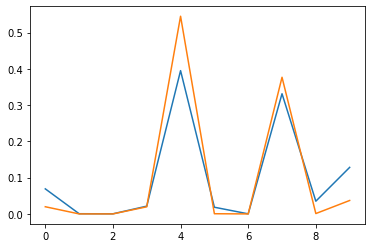

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed. 

This process includes the analytical effect of the nuisances, and their interdependence, since the augmented batch is passed through the model. This does, however, require that the effect of each nuisance on the input features is accurately parameterised.

Running cycle is:
1. on_train_begin: set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$.
1. for e in #epochs:
    1. for b in #batches:
        1. on_batch_begin: add relevant nuisances to incoming batch of inputs (as implemented in inheriting function)
        1. on_forwards_end:
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included since they're added to the input data and passed through the model)
            1. invert hessian , and set the diagonal element corresponding to $\mu$ as the loss value
        1. on_batch_end: zero gradient of alpha

In [ ]:
# export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model'''
    def __init__(self, b_true:float, mu_true:float, n_shape_alphas:int=0, s_shape_alpha:bool=False, b_shape_alpha:bool=False, nonaux_b_norm:bool=False,
                 shape_aux:Optional[List[Distribution]]=None, b_norm_aux:Optional[List[Distribution]]=None, s_norm_aux:Optional[List[Distribution]]=None):
        super().__init__()
        store_attr()
        if len(self.shape_aux) != self.n_shape_alphas: raise ValueError("Number of auxillary measurements on shape nuisances must match the number of shape nuisance parameters")
        self.n=self.mu_true+self.b_true
        # Norm uncertainties
        if self.s_norm_aux is None: self.s_norm_aux = []
        if self.b_norm_aux is None: self.b_norm_aux = []
        # Compute nuisance indeces
        self.poi_idx = [0]
        self.shape_idxs = list(range(1,self.n_shape_alphas+1))
        self.n_alpha = 1+self.n_shape_alphas
        self.s_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.s_norm_aux)))
        self.n_alpha += len(self.s_norm_aux)
        self.b_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.b_norm_aux)+self.nonaux_b_norm))
        self.n_alpha += len(self.b_norm_aux)+self.nonaux_b_norm
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)  # Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[self.poi_idx] = self.mu_true  # POI set to true value
                
    def on_batch_begin(self) -> None:
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def _aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor, f_s_asimov:Tensor, f_b_asimov:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        # Compute nll
        s_exp = self.alpha[self.poi_idx]+self.alpha[self.s_norm_idxs].sum() if len(self.s_norm_idxs) > 0 else self.alpha[self.poi_idx]
        b_exp = self.b_true             +self.alpha[self.b_norm_idxs].sum() if len(self.b_norm_idxs) > 0 else self.b_true
        t_exp  = (s_exp*f_s)+(b_exp*f_b)
        asimov = (self.mu_true*f_s)+(self.b_true*f_b_asimov)
        nll = -torch.distributions.Poisson(t_exp).log_prob(asimov).sum()
        # Constrain nll
        if self.shape_aux is not None:
            for a,x in zip(self.alpha[self.shape_idxs], self.shape_aux):
                if x is not None: nll = nll-x.log_prob(a)
        if len(self.b_norm_idxs):
            for i,x in zip(self.b_norm_idxs, self.b_norm_aux): nll = nll-x.log_prob(self.alpha[i])
        if len(self.s_norm_idxs):
            for i,x in zip(self.s_norm_idxs, self.s_norm_aux): nll = nll-x.log_prob(self.alpha[i])
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        return torch.inverse(h)[self.poi_idx,self.poi_idx]
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''        
        # Shapes with derivatives w.r.t. nuisances
        f_s = self.to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = self.to_shape(self.wrapper.y_pred[self.b_mask])
        # Shapes without derivatives w.r.t. nuisances
        f_s_asimov = self.to_shape(self.wrapper.model(self.wrapper.x[~self.b_mask].detach())) if self.s_shape_alpha else f_s
        f_b_asimov = self.to_shape(self.wrapper.model(self.wrapper.x[self.b_mask].detach()))  if self.b_shape_alpha else f_b
        
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b, f_s_asimov=f_s_asimov, f_b_asimov=f_b_asimov)

In [ ]:
#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    @delegates(AbsInferno, but=['b_shape_alpha', 's_shape_alpha'])
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, b_true:float=1000, mu_true:float=50, **kwargs):
        super().__init__(b_true=b_true, mu_true=mu_true, n_shape_alphas=float_r+float_l, b_shape_alpha=True, **kwargs)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def _aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[self.shape_idxs[0]]
        if self.float_l: x[self.b_mask,2] *= (self.alpha[self.shape_idxs[-1]]+self.l_init)/self.l_init

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(1, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,2), Normal(0,2)], nonaux_b_norm=True, b_norm_aux=[Normal(0,100)]),
               LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(2)])

1: Train=1915.6907385253905 Valid=1044.7411889648438
2: Train=1222.233273010254 Valid=1301.3044738769531
3: Train=879.8360180664063 Valid=807.3119201660156
4: Train=733.3637579345703 Valid=693.8331115722656
5: Train=598.3599996948242 Valid=558.8588708496094
Loading best model with loss 558.8588708496094
CPU times: user 2min 7s, sys: 31.2 s, total: 2min 38s
Wall time: 2min 9s


In [ ]:
model.save('weights/Inferno_Test_exact_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_exact_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,3,1.0
1,2,1.0
2,4,1.0
3,5,1.0
4,2,1.0


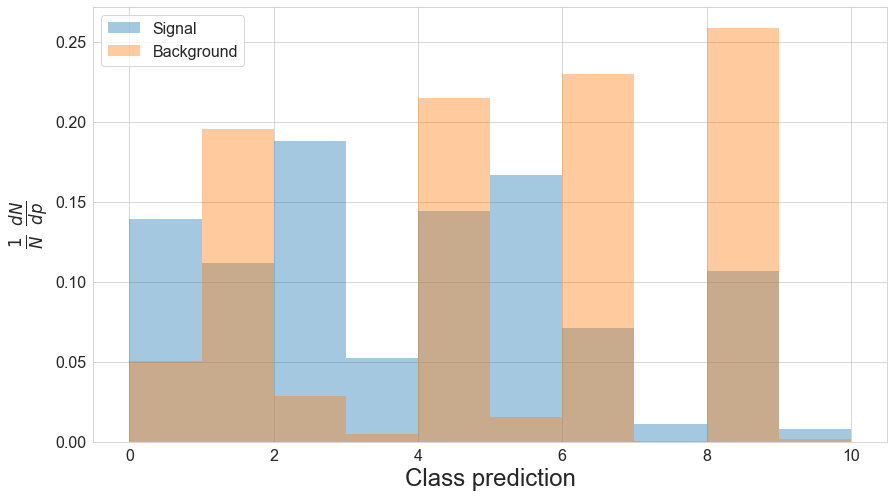

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,2,1.0,2
2,4,1.0,4
3,5,1.0,5
4,2,1.0,2


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
assert f_s.sum()==f_b.sum()==1

(tensor(1.), tensor(1.))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([ 57.2275, 200.8486,  37.9805,   7.3056, 222.2597,  24.0025, 233.1603,
           1.0869, 264.1640,   1.9644]), tensor(1050.))

In [ ]:
n = 1050
mu_scan = torch.linspace(20,80,61)
y = torch.zeros_like(mu_scan)
for i,m in enumerate(mu_scan):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

tensor([28.6126, 28.5003, 28.3919, 28.2886, 28.1896, 28.0947, 28.0045, 27.9185,
        27.8364, 27.7588, 27.6852, 27.6156, 27.5501, 27.4885, 27.4307, 27.3768,
        27.3266, 27.2804, 27.2378, 27.1985, 27.1632, 27.1315, 27.1031, 27.0783,
        27.0568, 27.0387, 27.0244, 27.0129, 27.0049, 26.9999, 26.9985, 26.9999,
        27.0045, 27.0126, 27.0236, 27.0376, 27.0543, 27.0740, 27.0970, 27.1226,
        27.1512, 27.1830, 27.2176, 27.2544, 27.2943, 27.3370, 27.3823, 27.4304,
        27.4812, 27.5345, 27.5903, 27.6486, 27.7099, 27.7735, 27.8394, 27.9080,
        27.9791, 28.0528, 28.1285, 28.2069, 28.2877])

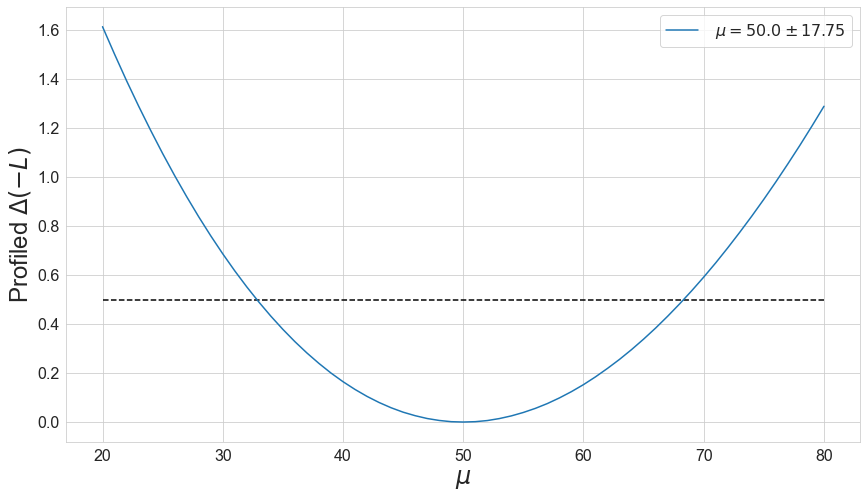

In [ ]:
w1 = plot_likelihood(y, mu_scan=mu_scan)

In [ ]:
profiler = partialler(calc_profile, f_s_nom=f_s, f_b_nom=f_b, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100)

In [ ]:
nll = profiler()

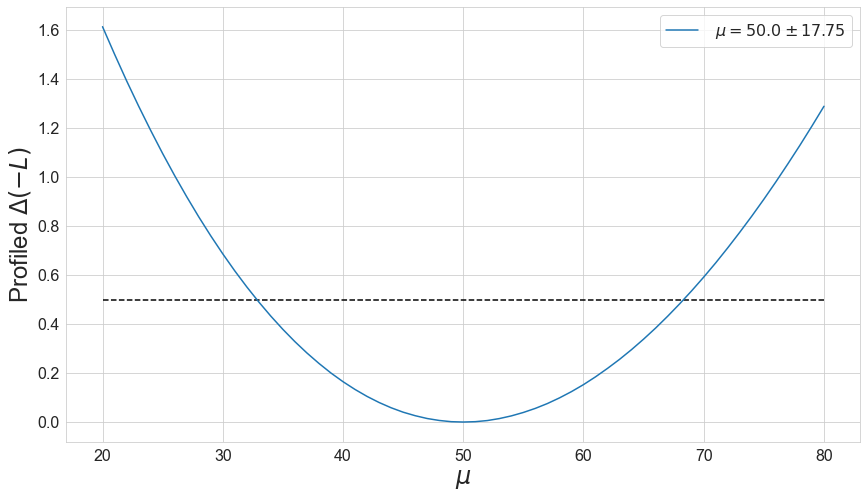

In [ ]:
w2 = plot_likelihood(nll, mu_scan=mu_scan)

In [ ]:
assert w1 == w2

# Nuisances

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,4,1.0,4,4,4,4,4,4,4,4,4,4,4
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999996,6,0.0,6,1,1,6,6,6,6,6,6,6,6
999997,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999998,8,0.0,8,4,4,8,8,8,8,4,4,8,8


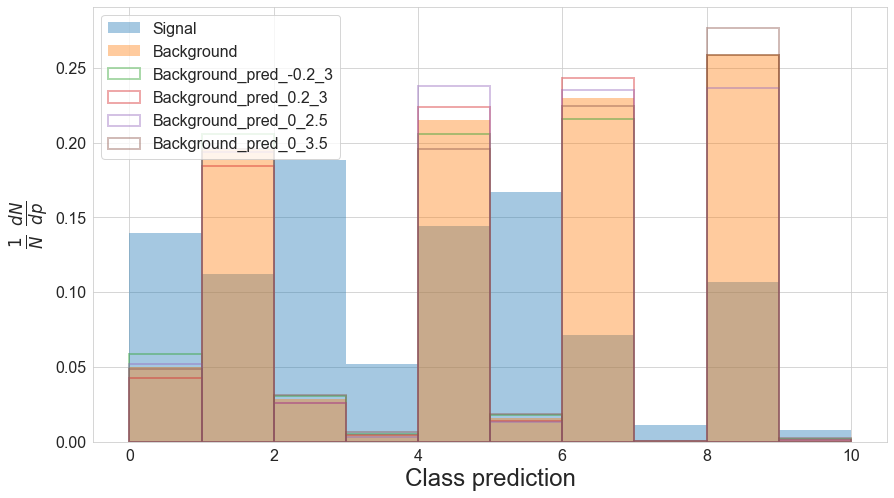

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.0607, 0.2044, 0.0280, 0.0038, 0.2286, 0.0150, 0.2214, 0.0004, 0.2366,
        0.0010])
tensor([0.0590, 0.2056, 0.0306, 0.0051, 0.2055, 0.0177, 0.2157, 0.0006, 0.2586,
        0.0016])
tensor([0.0572, 0.2064, 0.0333, 0.0067, 0.1861, 0.0203, 0.2103, 0.0008, 0.2766,
        0.0023])
tensor([0.0520, 0.1940, 0.0260, 0.0034, 0.2381, 0.0130, 0.2354, 0.0003, 0.2368,
        0.0010])
tensor([0.0503, 0.1952, 0.0286, 0.0047, 0.2150, 0.0157, 0.2296, 0.0005, 0.2588,
        0.0016])
tensor([0.0485, 0.1960, 0.0313, 0.0062, 0.1956, 0.0183, 0.2242, 0.0008, 0.2769,
        0.0023])
tensor([4.4378e-02, 1.8334e-01, 2.3594e-02, 3.0760e-03, 2.4720e-01, 1.1386e-02,
        2.4922e-01, 2.3200e-04, 2.3672e-01, 8.5400e-04])
tensor([0.0427, 0.1846, 0.0262, 0.0044, 0.2241, 0.0140, 0.2434, 0.0004, 0.2587,
        0.0014])
tensor([0.0409, 0.1853, 0.0289, 0.0059, 0.2047, 0.0166, 0.2381, 0.0007, 0.2768,
        0.0022])


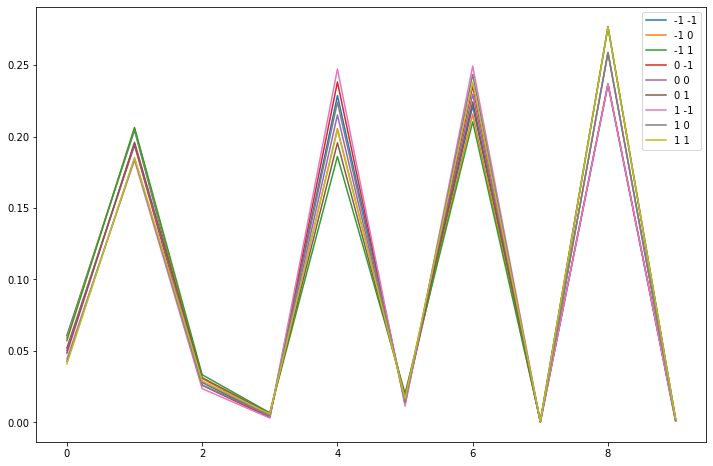

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

## BM 1
r free, l fixed

In [ ]:
nll = profiler(f_b_up=b_shapes['f_b_up'][0], f_b_dw=b_shapes['f_b_dw'][0])

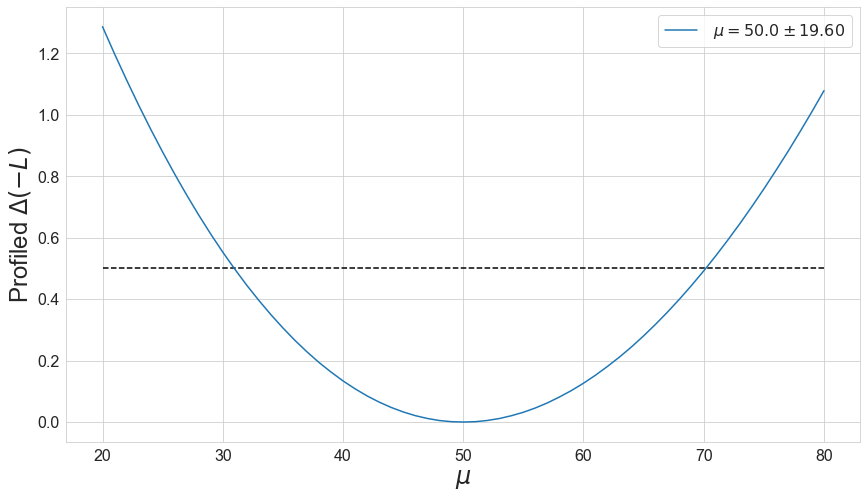

[19.603393349433645]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 1l
r fixed, l free

In [ ]:
nll = profiler(f_b_up= b_shapes['f_b_up'][1], f_b_dw=b_shapes['f_b_dw'][1])

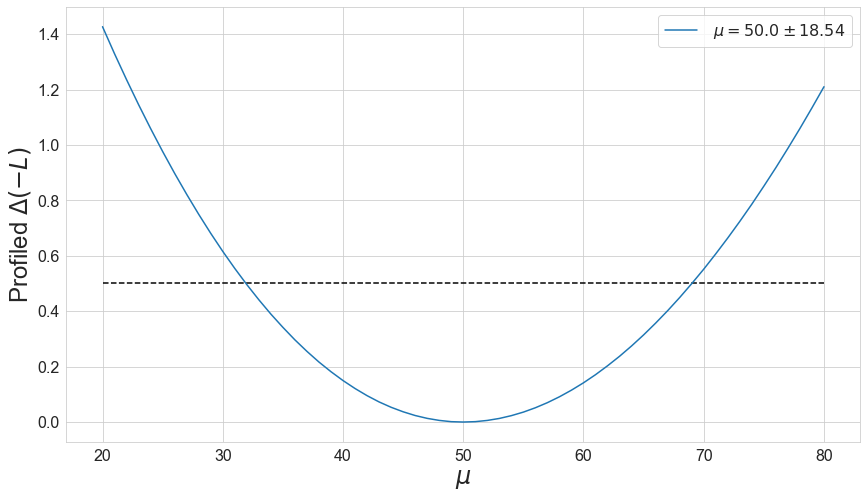

[18.539771185884273]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 2

In [ ]:
nll = profiler(**b_shapes)

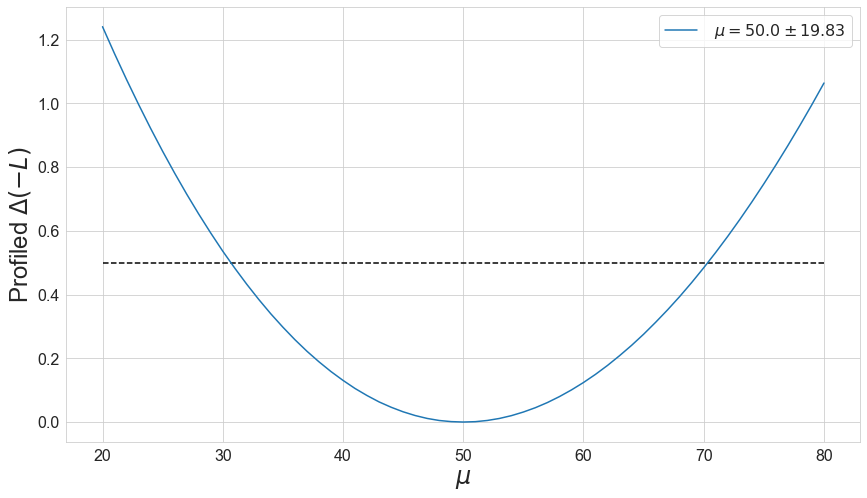

[19.83229081995841]

In [ ]:
plot_likelihood(nll, mu_scan)

In [ ]:
b_shapes

OrderedDict([('f_b_nom',
              tensor([[0.0503, 0.1952, 0.0286, 0.0047, 0.2150, 0.0157, 0.2296, 0.0005, 0.2588,
                       0.0016]])),
             ('f_b_up',
              tensor([[0.0427, 0.1846, 0.0262, 0.0044, 0.2241, 0.0140, 0.2434, 0.0004, 0.2587,
                       0.0014],
                      [0.0485, 0.1960, 0.0313, 0.0062, 0.1956, 0.0183, 0.2242, 0.0008, 0.2769,
                       0.0023]])),
             ('f_b_dw',
              tensor([[0.0590, 0.2056, 0.0306, 0.0051, 0.2055, 0.0177, 0.2157, 0.0006, 0.2586,
                       0.0016],
                      [0.0520, 0.1940, 0.0260, 0.0034, 0.2381, 0.0130, 0.2354, 0.0003, 0.2368,
                       0.0010]]))])

In [ ]:
f_s

tensor([[0.1393, 0.1121, 0.1881, 0.0523, 0.1442, 0.1668, 0.0714, 0.0112, 0.1066,
         0.0079]])

## BM 3

In [ ]:
shape_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(shape_aux=shape_aux, **b_shapes)

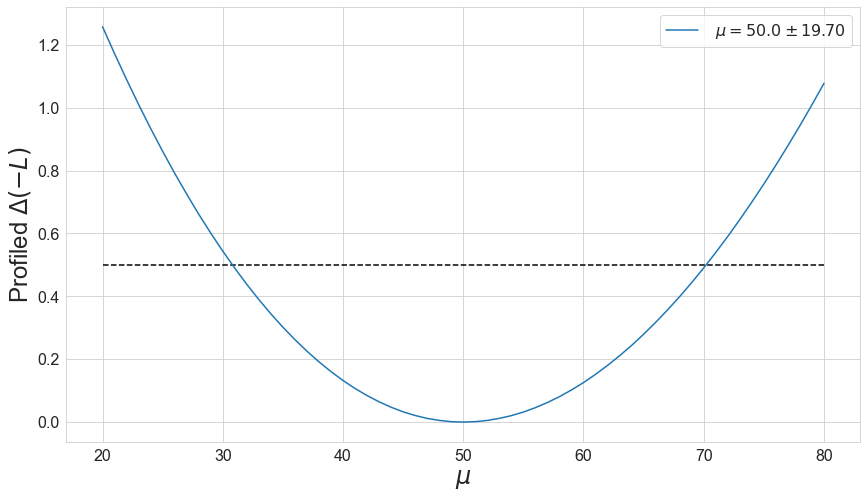

[19.698443151459262]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 4

In [ ]:
nll = profiler(shape_aux=shape_aux, b_norm_aux=[Normal(0,100)], **b_shapes)

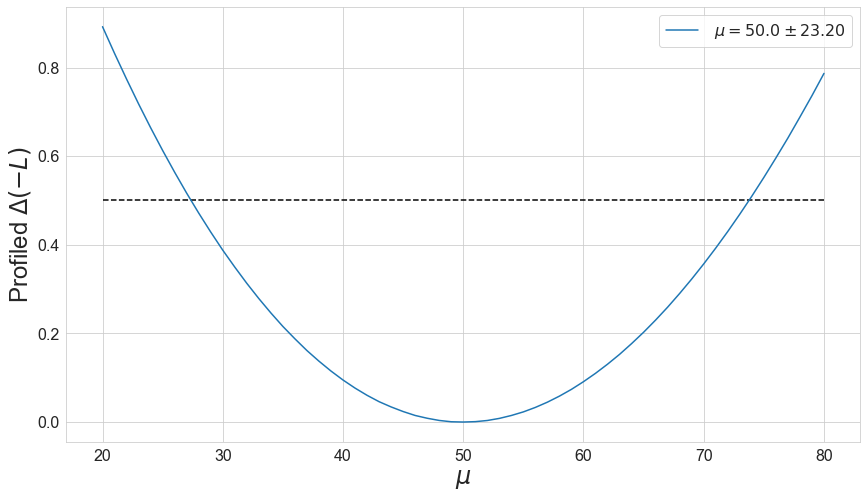

[23.20257568151854]

In [ ]:
plot_likelihood(nll, mu_scan)